# Past Processing

The primary aim of this notebook is to provide a framework for handling and analyzing past data, enabling users to extract meaningful insights and visualize trends over time.

#### Methods Defined
1. **read_image(image_path)**:
   - **Purpose**: Reads an image from the specified path in grayscale.
   - **Parameters**: `image_path` - The path to the image file.
   - **Returns**: Grayscale image array.

2. **binarize_image(image_path, threshold)**:
   - **Purpose**: Converts a grayscale image to a binary image based on a threshold.
   - **Parameters**: 
     - `image_path` - The path to the image file.
     - `threshold` - The threshold value for binarization.
   - **Returns**: Binary image array.

3. **erosion(label, erosion_size)**:
   - **Purpose**: Applies binary erosion to an image label.
   - **Parameters**: 
     - `label` - The label image array.
     - `erosion_size` - The size of the erosion kernel.
   - **Returns**: Eroded image array.

4. **dilation(image, dilation_size)**:
   - **Purpose**: Applies binary dilation to an image.
   - **Parameters**: 
     - `image` - The image array.
     - `dilation_size` - The size of the dilation kernel.
   - **Returns**: Dilated image array.

5. **overlay_mask(image, mask)**:
   - **Purpose**: Overlays a mask on an image, highlighting certain areas.
   - **Parameters**: 
     - `image` - The original image array.
     - `mask` - The binary mask array.
   - **Returns**: Color image with the mask overlaid.

#### Processing Steps
1. **Reading Images**:
   - Reads the original image and the label image from the specified paths.

2. **Equalization and Normalization**:
   - Applies histogram equalization to both the image and the label for contrast adjustment.
   - Performs min-max normalization on the equalized label.

3. **Binarization**:
   - Converts the normalized label to a binary image based on a threshold.

4. **Erosion and Dilation**:
   - Applies erosion followed by dilation to the binarized label for morphological operations.

5. **Overlaying Masks**:
   - Overlays the processed mask onto the original image.
   - Applies further erosion to create another mask and overlay it in a different color.

6. **Visualization**:
   - Plots the final image with the masks overlaid.

These methods are designed to process images, particularly for tasks like segmentation and highlighting specific regions in the images using morphological operations.


In [3]:
from skimage import morphology
import skimage.io as sio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [4]:
def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def binarize_image(image_path, threshold):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.where(image > threshold, 1, 0).astype(np.float32)

def erosion(label, erosion_size):
    markers = np.zeros_like(label)
    for i in range(1, int(label.max()) + 1):
        mask = label == i
        eroded_mask = morphology.binary_erosion(mask, np.ones((erosion_size, erosion_size)))
        markers[eroded_mask] = 1
    return markers.astype('float32')

def dilation(image, dilation_size):
    markers = np.zeros_like(image)
    for i in range(1, int(image.max()) + 1):
        mask = image == i
        dilated_mask = morphology.binary_dilation(mask, np.ones((dilation_size, dilation_size)))
        border_mask = dilated_mask & ~mask
        markers[border_mask] = 1
    return markers.astype('float32') 

def overlay_mask(image, mask):
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    color_image[mask == 1] = [255, 0, 0]  
    return color_image


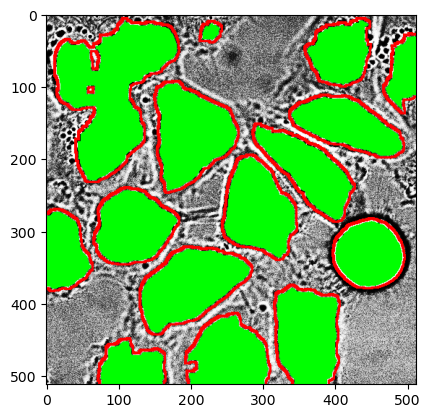

In [109]:

image_path = 'Data/test/02/t083.tif'
label_path = 'Data/output_image/val_epoch_29_batch_20.tif'

image = read_image(image_path)
label = read_image(label_path)

# Apply Min-Max Normalization
equalized_label = cv2.equalizeHist(label)
equalized_image = cv2.equalizeHist(image)

min_val = np.min(equalized_label)
max_val = np.max(equalized_label)


min_max_normalized_image = (equalized_label - min_val) / (max_val - min_val) * 255
min_max_normalized_image = min_max_normalized_image.astype(np.uint8)


binarized_label = np.where(min_max_normalized_image > 90, 1, 0).astype(np.float32)

eroded_label = erosion(binarized_label, 8)

dilated_label = dilation(eroded_label,8)


masked_image = overlay_mask(equalized_image, dilated_label)

eroded_label2 = erosion(binarized_label, 10)

masked_image[eroded_label2 == 1] = [0, 255, 0]  





plt.imshow(masked_image, cmap='gray')
